# Transformer架构（变形金刚）

Transformer虽然也是基于Encoder-Decoder的架构去处理一个序列对（比如一句英语和一句法语）。

但Transformer模型完全基于注意力机制，没有任何RNN，这是与使用attention的seq2seq（用到了RNN）架构不同的地方。


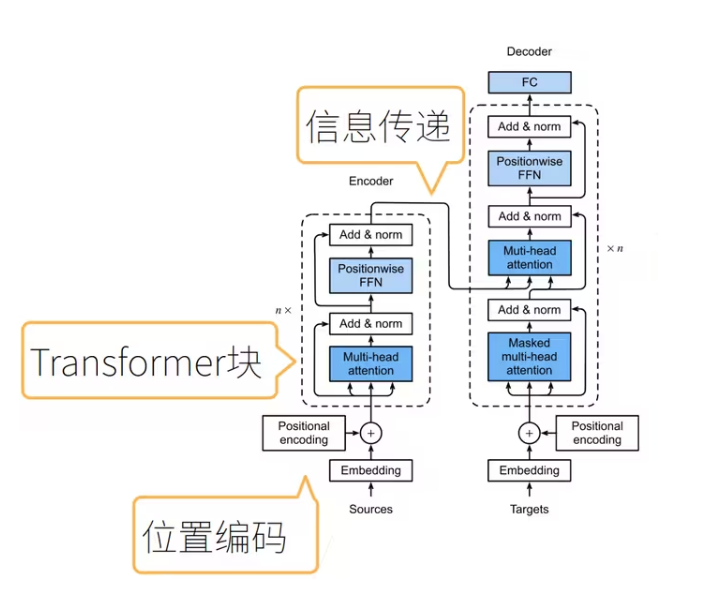

Transformer模型完全基于注意力机制，没有任何卷积层或循环神经网络层 (Vaswani et al., 2017)

Transformer作为编码器－解码器架构的一个实例

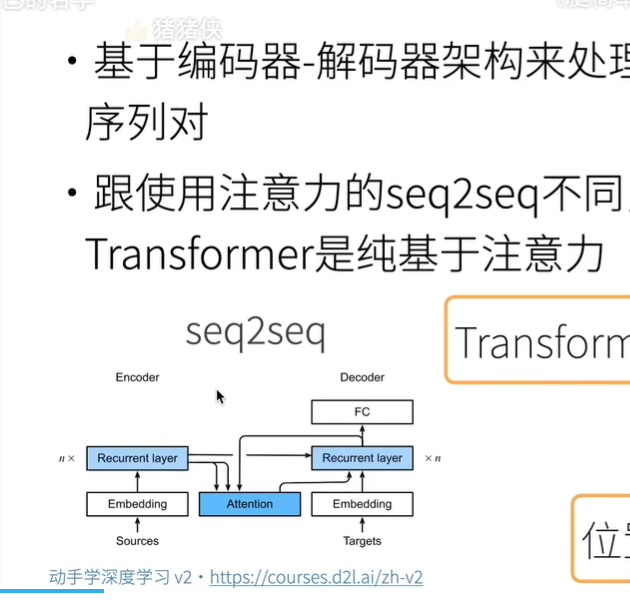

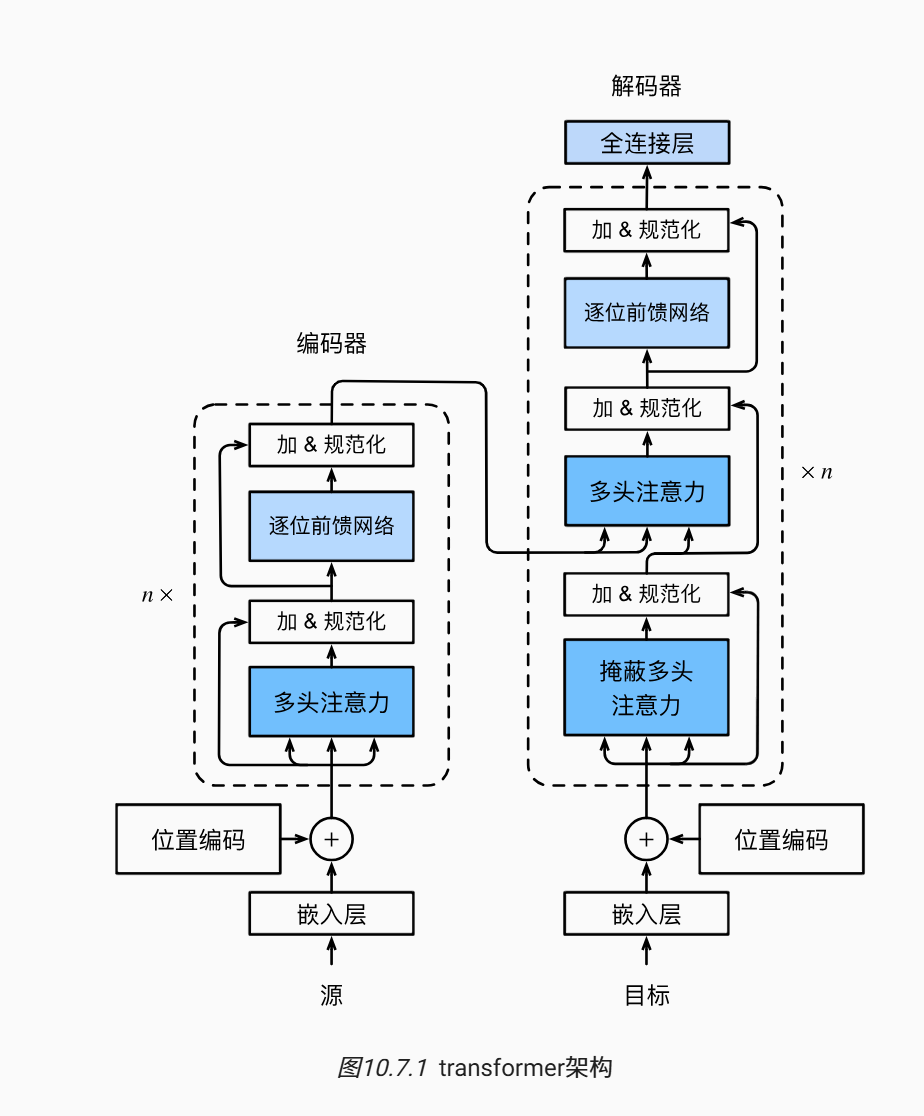

先加个位置编码

因为后面的Transformer块不会提供位置信息

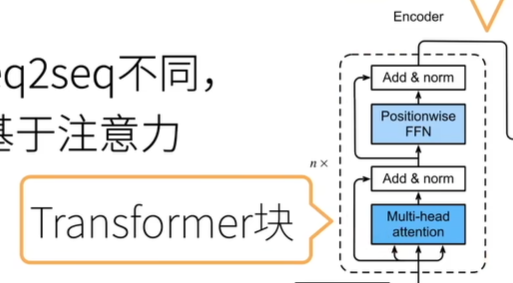

Transformer 的编码器是由多个相同的层叠加而成的，每个层都有两个子层（每个子层都采用了残差连接，并且在残差连接的加法计算之后，都使用了层归一化，因此 Transformer 编码器都将输出一个 d 维表示向量）


# 第一子层多头注意力（多个自注意力）

Transformer 块中的多头注意力实际上就是自注意力（自注意力同时具有并行计算和最短的最大路径长度这两个优势）
在计算编码器的自注意力时，key 、value 和 query 的值都来自前一个编码器层的输出

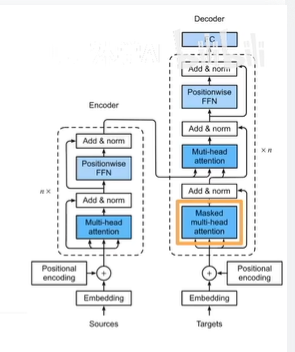
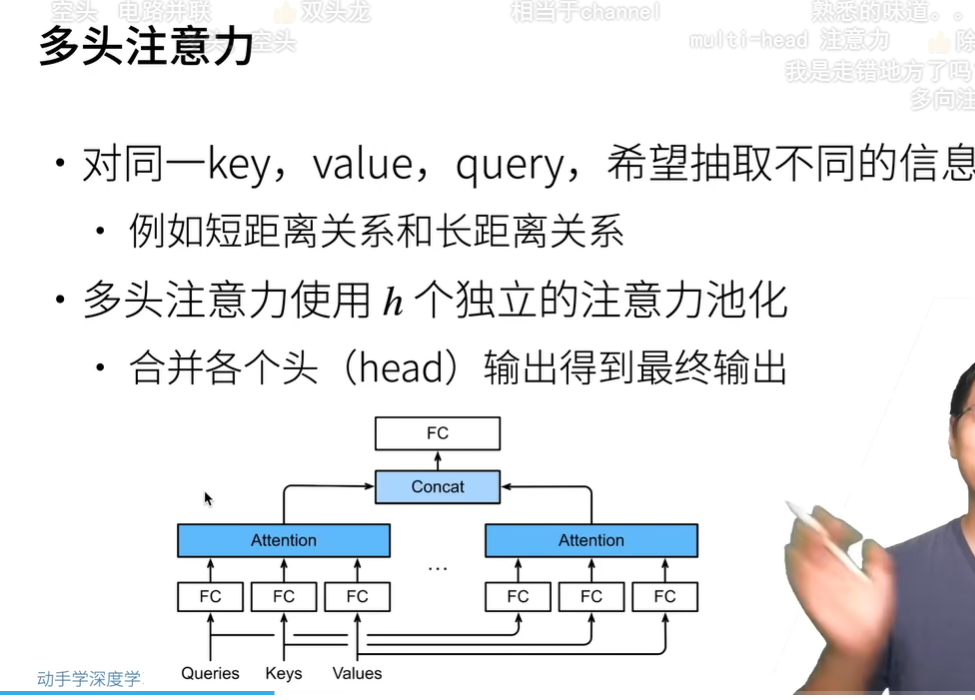

多头注意力的主要目的是通过并行地应用多个注意力机制（称为“头”）来提高模型对信息的捕获能力。

Transformer 块中的多头注意力实际上就是自注意力（自注意力同时具有并行计算和最短的最大路径长度这两个优势）
在计算编码器的自注意力时，key 、value 和 query 的值都来自前一个编码器层的输出

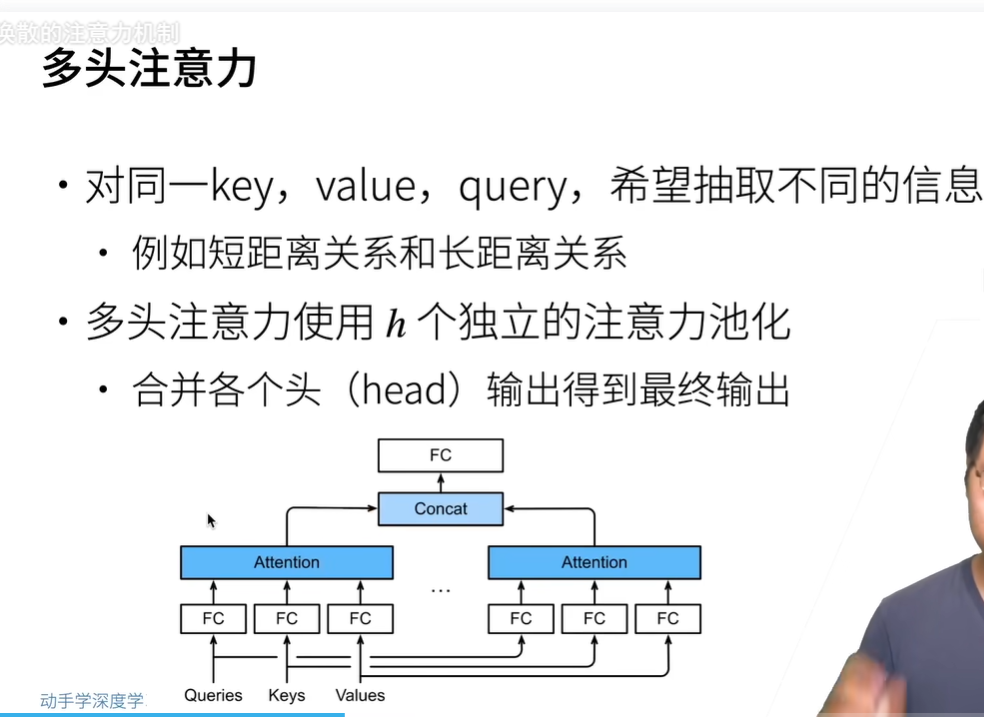

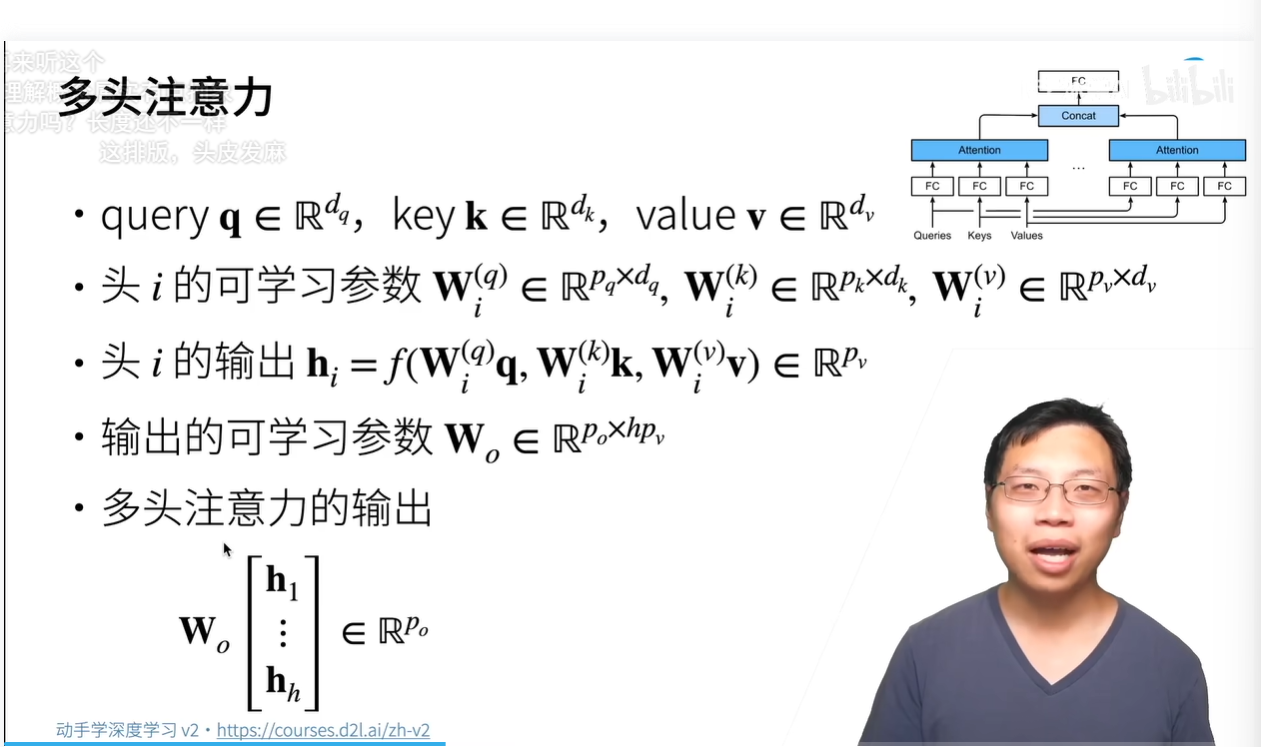

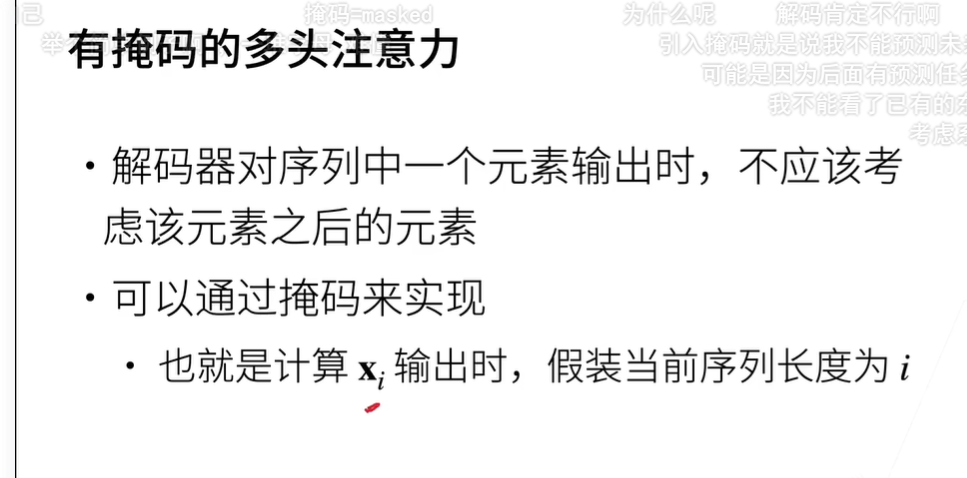

# 第二子层基于位置的前馈网络

是一个全连接层。本质上和编码器-解码器的架构没有本质上的区别，将 Transformer 编码器最后一层的输出作为解码器的输入来完成信息的传递
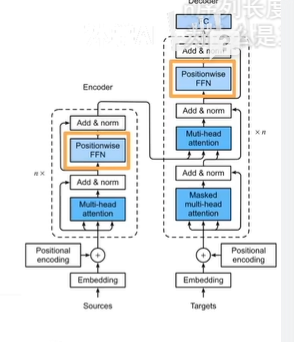
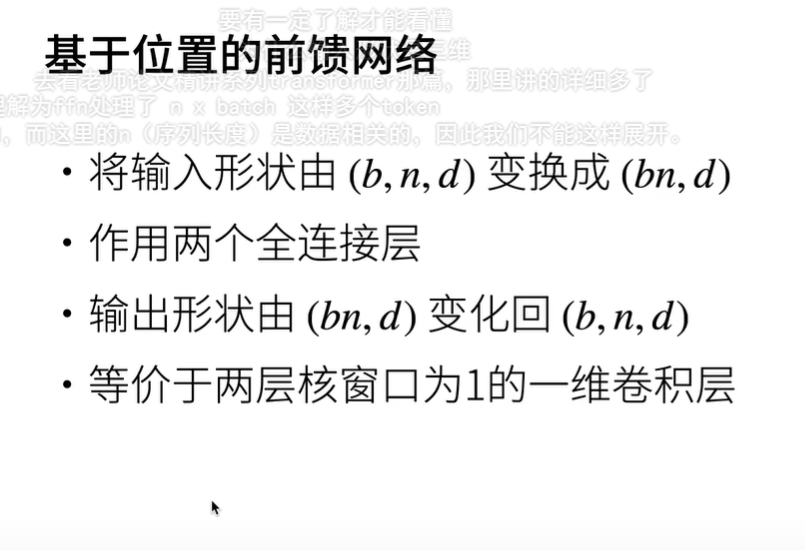

# 层归一化
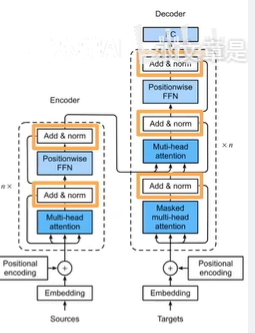
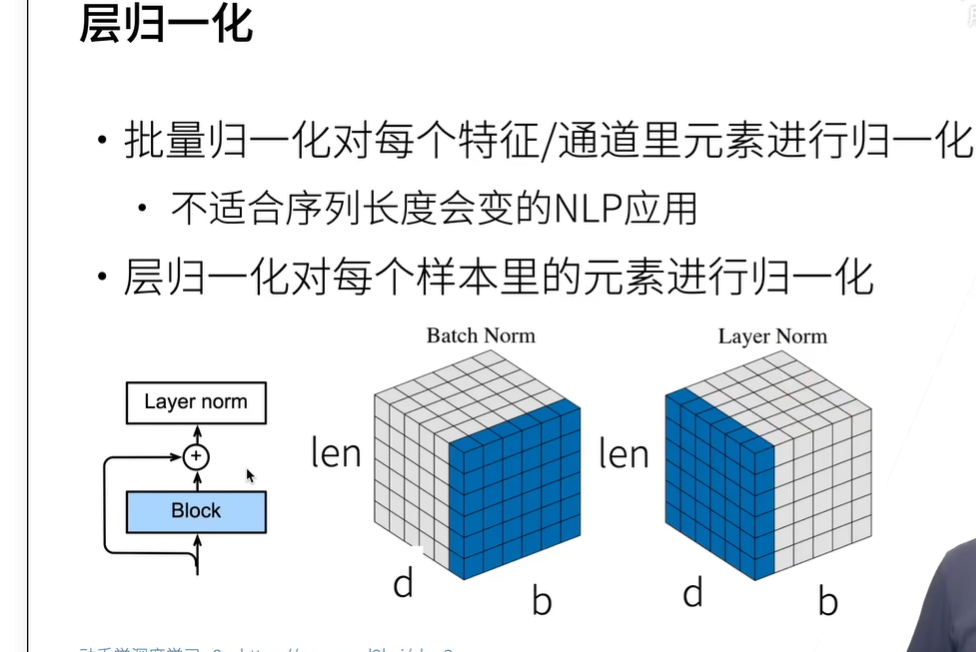

# 信息传递

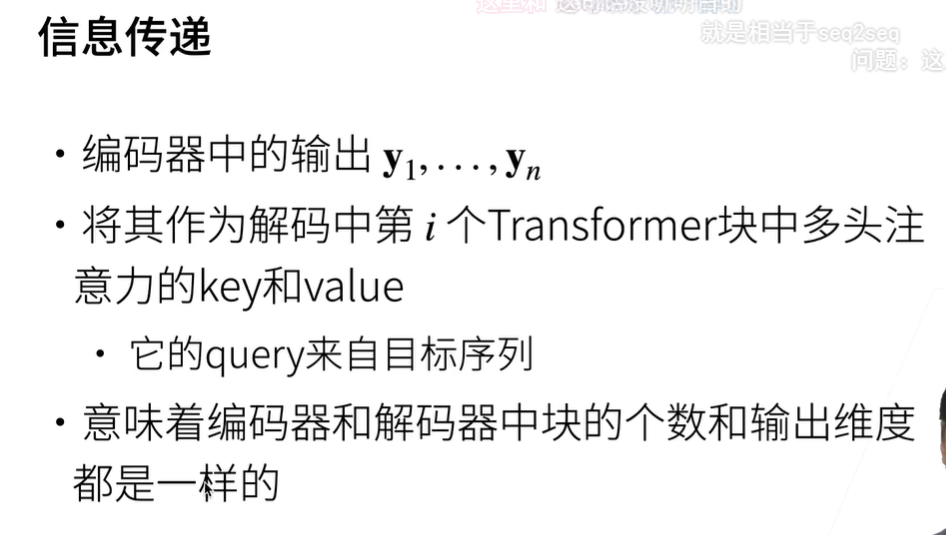

# 预测

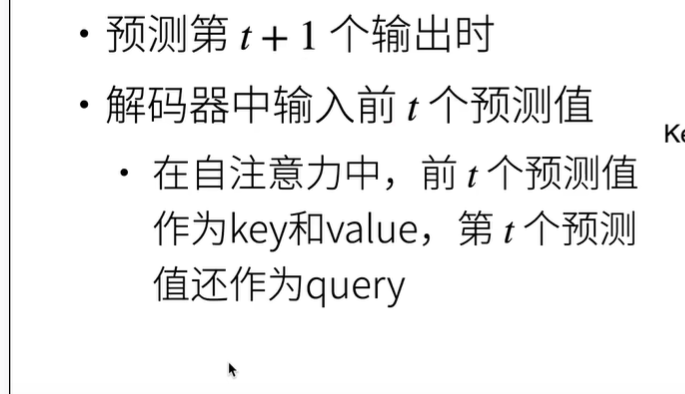

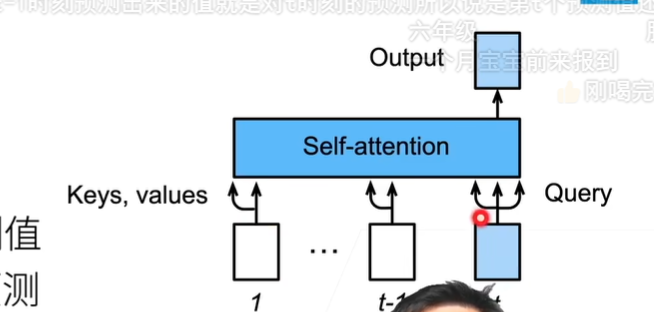

# 总结
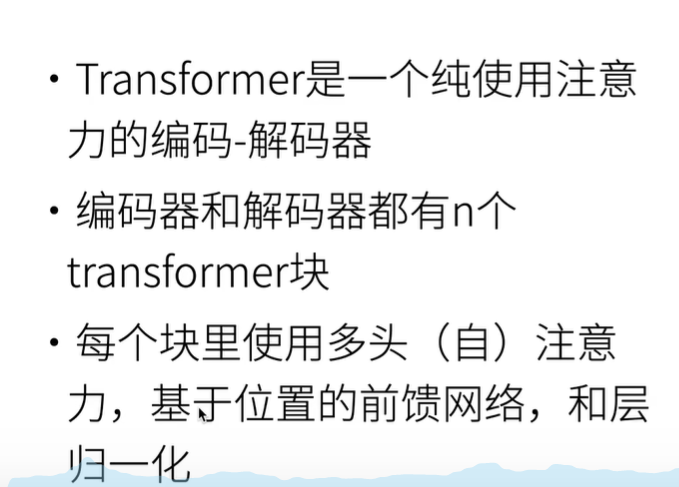

In [2]:
# 多头注意力代码
import math
import torch
from torch import nn
from d2l import torch as d2l

与其只使用单独一个注意力汇聚， 我们可以用独立学习得到的
多组不同的 线性投影（linear projections）来变换查询、键和值。 然后，这
多组变换后的查询、键和值将并行地送到注意力汇聚中。 最后，将这
多个注意力汇聚的输出拼接在一起， 并且通过另一个可以学习的线性投影进行变换， 以产生最终输出。 这种设计被称为多头注意力（multihead attention） 
对于多个注意力汇聚输出，每一个注意力汇聚都被称作一个头（head）
展示了使用全连接层来实现可学习的线性变换的多头注意力。

![image.png](attachment:image.png)

In [3]:
# @save 指令表示在使用 d2l 库时，将此类保存到文件中
class MultiHeadAttention(nn.Module):
    """多头注意力机制"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        """初始化多头注意力
        参数:
        - key_size: 键的特征维度
        - query_size: 查询的特征维度
        - value_size: 值的特征维度
        - num_hiddens: 隐藏层的特征维度
        - num_heads: 注意力头的数量
        - dropout: dropout比率
        - bias: 线性层是否使用偏置
        """
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads  # 设置注意力头的数量
        self.attention = d2l.DotProductAttention(dropout)  # 引入点积注意力机制
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)  # 查询向量的线性变换
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)  # 键向量的线性变换
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)  # 值向量的线性变换
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)  # 最后的输出线性变换

    def forward(self, queries, keys, values, valid_lens):
        """前向传播
        
        参数:
        - queries: 查询向量，形状为 (batch_size, 查询个数, num_hiddens)
        - keys: 键向量，形状为 (batch_size, 键个数, num_hiddens)
        - values: 值向量，形状为 (batch_size, 值个数, num_hiddens)
        - valid_lens: 有效长度，形状为 (batch_size,) 或 (batch_size, 查询个数)

        返回:
        - output: 应用多头注意力计算后得到的输出，形状为 (batch_size, 查询个数, num_hiddens)
        """
        # 在这里计算查询、键、值的线性变换并进行维度调整
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # 在valid_lens的维度0上将其扩展为num_heads倍
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # 使用点积注意力计算输出
        output = self.attention(queries, keys, values, valid_lens)

        # 合并多个头的输出
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)  # 最终通过线性层输出